In [1]:
%load_ext cuml.accel

cuML: Accelerator installed.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdelmalekeladjelet/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC , LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import time
from sklearn.experimental import enable_halving_search_cv

In [109]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/sentiment_data.csv' , encoding='latin-1')

   Unnamed: 0                                            Comment  Sentiment  \
0           0  lets forget apple pay required brand new iphon...          1   
1           1  nz retailers donât even contactless credit c...          0   
2           2  forever acknowledge channel help lessons ideas...          2   
3           3  whenever go place doesnât take apple pay doe...          0   
4           4  apple pay convenient secure easy use used kore...          2   

   text_length  
0           33  
1           18  
2           15  
3           49  
4           14  
Sentiment
2    103059
1     82972
0     55114
Name: count, dtype: int64


/tmp/ipython-input-228264574.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


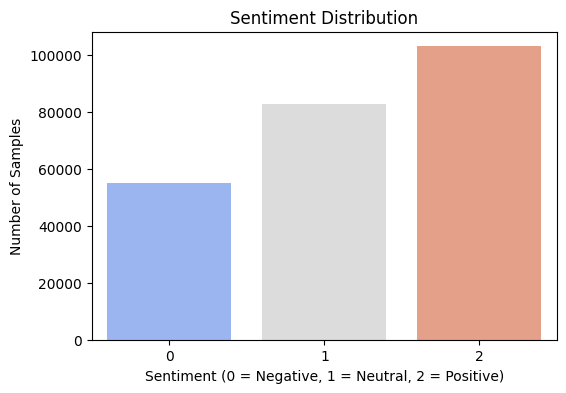

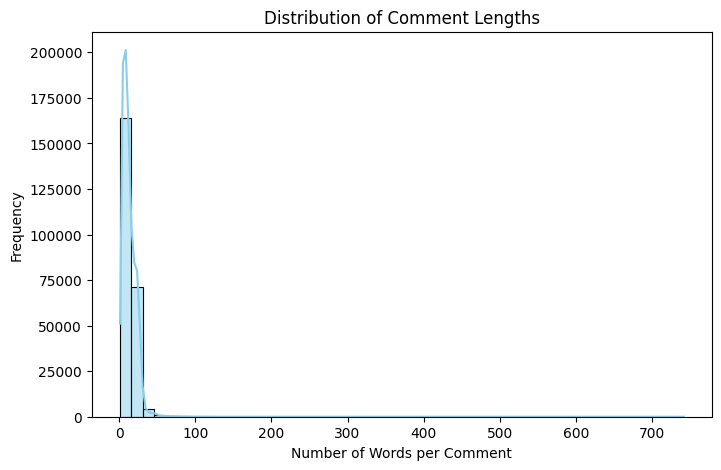

In [115]:
# Check first few rows
print(df.head())

# Rename columns if necessary (the dataset uses 'Comment' and 'Sentiment')

# Basic info
print(df['Sentiment'].value_counts())

# ==============================
# 1️⃣ Sentiment Distribution Bar Graph
# ==============================
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0 = Negative, 1 = Neutral, 2 = Positive)")
plt.ylabel("Number of Samples")
plt.show()

# ==============================
# 2️⃣ Comment Length Distribution
# ==============================
df['text_length'] = df['Comment'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Words per Comment")
plt.ylabel("Frequency")
plt.show()



In [6]:
df.head()

,Unnamed: 0,Comment,Sentiment,text_length
0,0,lets forget apple pay required brand new iphon...,1,33
1,1,nz retailers donât even contactless credit c...,0,18
2,2,forever acknowledge channel help lessons ideas...,2,15
3,3,whenever go place doesnât take apple pay doe...,0,49
4,4,apple pay convenient secure easy use used kore...,2,14


In [7]:
print(df.isnull().sum())


Unnamed: 0       0
Comment        217
Sentiment        0
text_length      0
dtype: int64


In [8]:
df.dropna(inplace=True)

In [9]:
print(df.isnull().sum())


Unnamed: 0     0
Comment        0
Sentiment      0
text_length    0
dtype: int64


In [119]:
df = df.drop(columns=['Unnamed: 0'])

In [120]:
df = df.drop(columns=['text_length'])

In [12]:
df.head()

,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers donât even contactless credit c...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesnât take apple pay doe...,0
4,apple pay convenient secure easy use used kore...,2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240928 entries, 0 to 241144
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Comment    240928 non-null  object
 1   Sentiment  240928 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [14]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

In [16]:
# import re
# def remove_stopwords(text):
#     if isinstance(text, str):
#         remove_num  = re.sub(r'[^A-Za-z\s]', '', text) #delete number
#         cleaned = re.sub(r'[^A-Za-z0-9\s\.]','',remove_num) #delete special Char
#         tokens = word_tokenize(cleaned)
#         tokens = " ".join(word for word in tokens)
#         tokens = ",".join(word for word in tokens.split() if word.lower not in eng_stopwords)
#         return tokens
#     else:
#         return ""

In [117]:
def clean_text(text):
    if isinstance(text, str):
        # ลบตัวเลข
        text = re.sub(r'\d+', '', text)
        # ลบ special characters ยกเว้น space
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # แปลงเป็น lowercase
        text = text.lower()
        # tokenize
        tokens = word_tokenize(text)
        # ลบ stopwords
        tokens = [word for word in tokens if word not in eng_stopwords]
        return ' '.join(tokens)
    else:
        return ''

# ใช้กับคอลัมน์ text
df['clean_text'] = df['Comment'].apply(clean_text)


In [18]:
# df['tokens'] = df['Comment'].apply(remove_stopwords)
# df_select = df['tokens'].apply(select_text_by_sentiment)
# df = pd.concat([df, df_select.apply(pd.Series)], axis=1)


In [121]:
df.head()

,Comment,Sentiment,clean_text
0,lets forget apple pay required brand new iphon...,1,lets forget apple pay required brand new iphon...
1,nz retailers donât even contactless credit c...,0,nz retailers dont even contactless credit card...
2,forever acknowledge channel help lessons ideas...,2,forever acknowledge channel help lessons ideas...
3,whenever go place doesnât take apple pay doe...,0,whenever go place doesnt take apple pay doesnt...
4,apple pay convenient secure easy use used kore...,2,apple pay convenient secure easy use used kore...


In [20]:
sia = SentimentIntensityAnalyzer()

In [21]:
def select_words_by_sentiment(text, label):
    words = word_tokenize(text)
    selected_words = []

    for word in words:
        score = sia.polarity_scores(word)['compound']
        if label == 0 and score < -0.1:  # negative
            selected_words.append(word)
        elif label == 2 and score > 0.1:  # positive
            selected_words.append(word)
        elif label == 1 and -0.1 <= score <= 0.1:  # neutral
            selected_words.append(word)
    return ','.join(selected_words)

In [22]:
# df['top_word'] = df.apply(lambda row: select_words_by_sentiment(row['clean_text'], row['Sentiment']), axis=1)
df['selected_words'] = df.apply(lambda x: select_words_by_sentiment(x['clean_text'], x['Sentiment']), axis=1)


In [23]:
df.head()

,Comment,Sentiment,clean_text,selected_words
0,lets forget apple pay required brand new iphon...,1,lets forget apple pay required brand new iphon...,"lets,apple,required,brand,new,iphone,order,use..."
1,nz retailers donât even contactless credit c...,0,nz retailers dont even contactless credit card...,pay
2,forever acknowledge channel help lessons ideas...,2,forever acknowledge channel help lessons ideas...,"help,helpful,comfort,growth"
3,whenever go place doesnât take apple pay doe...,0,whenever go place doesnt take apple pay doesnt...,"pay,drag,pay,seriously,annoyed,shock,crazy,inc..."
4,apple pay convenient secure easy use used kore...,2,apple pay convenient secure easy use used kore...,"secure,easy,credit"


In [24]:
# from collections import Counter
# from nltk.tokenize import word_tokenize

# # ฟังก์ชันรวมคำที่ใช้บ่อยของข้อความแต่ละ sentiment
# def get_top_words_list(text_list, top_n=20):
#     all_tokens = []
#     for text in text_list:
#         tokens = word_tokenize(text)
#         all_tokens.extend(tokens)
#     counter = Counter(all_tokens)
#     # return เฉพาะคำที่ใช้บ่อยที่สุด
#     top_words = [word for word, freq in counter.most_common(top_n)]
#     return top_words

# # สร้างคอลัมน์ 'top_words' ตาม sentiment
# def assign_top_words(row):
#     if row['Sentiment'] == 0:
#         return get_top_words_list(negative_texts, top_n=20)
#     elif row['Sentiment'] == 1:
#         return get_top_words_list(neutral_texts, top_n=20)
#     elif row['Sentiment'] == 2:
#         return get_top_words_list(positive_texts, top_n=20)
#     else:
#         return []

# # สร้างคอลัมน์ top_words
# df['top_words'] = df.apply(assign_top_words, axis=1)

# # ดูตัวอย่าง
# df[['clean_text', 'Sentiment', 'top_words']].head()


In [25]:
pip install wordcloud

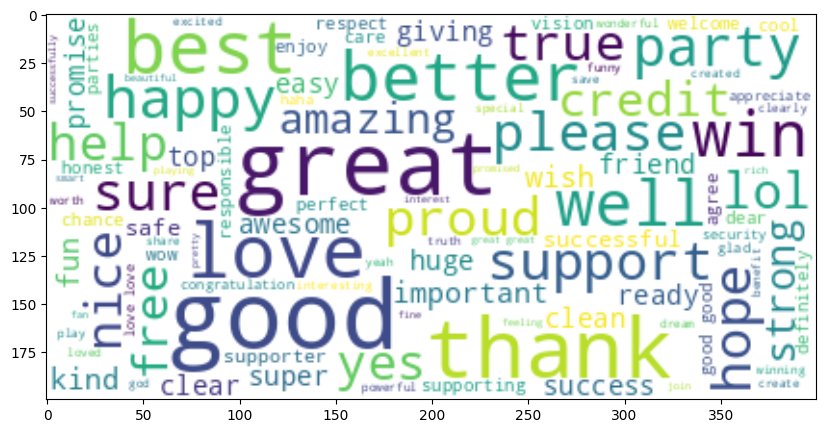

In [26]:
df_pos = df[df['Sentiment'] == 2]
pos_word_all = ' '.join(t for t in df_pos['selected_words'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_word_all)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()


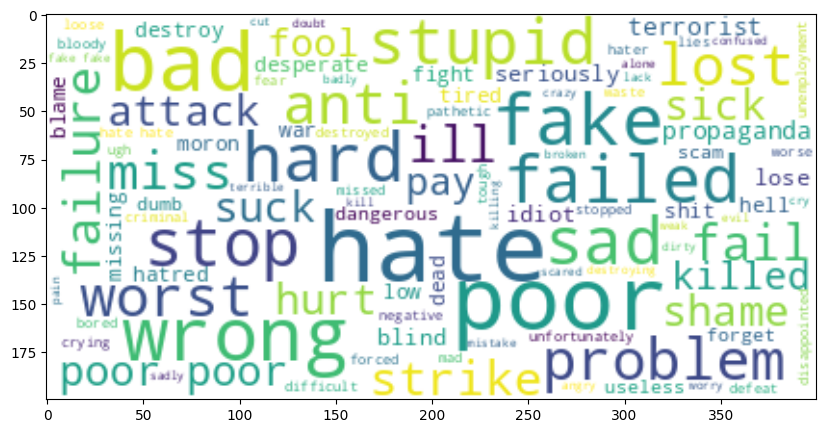

In [27]:
df_neg = df[df['Sentiment'] == 0]
neg_word_all = ' '.join(t for t in df_neg['selected_words'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_word_all)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()


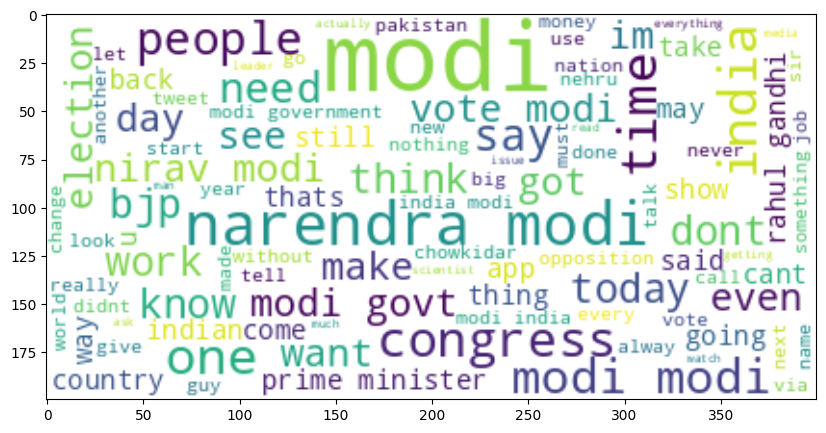

In [28]:
df_neu = df[df['Sentiment'] == 1]
neutral_word_all = ' '.join(t for t in df_neu['selected_words'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neutral_word_all)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()


In [29]:
X = df['selected_words']
y = df['Sentiment']

X_train , X_test , y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=100)

In [30]:
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = tvec.fit_transform(X_train)
X_test_tfidf = tvec.transform(X_test)



In [31]:
tvec = TfidfVectorizer(
    ngram_range=(1,2),              # unigrams + bigrams
    stop_words='english',           # remove common English stopwords
    max_features=10000,             # keep top 10k features
    min_df=3,                       # keep terms that appear in at least 3 docs
    token_pattern=r'\b[a-zA-Z]{2,}\b'  # only keep alphabetic tokens with >=2 letters
)

# Fit and transform training data
train_bow = tvec.fit_transform(X_train)

# Convert to DataFrame
train_bow_df = pd.DataFrame(
    train_bow.toarray(),
    columns=tvec.get_feature_names_out(),
    index=range(len(X_train))  # safer than using X_train directly
)

# Display
print(train_bow_df.head())

   aadhar  aadmi  aage  aaj  aaj tak  aalo  aam  aam aadmi  aap  aapke  ...  \
0     0.0    0.0   0.0  0.0      0.0   0.0  0.0        0.0  0.0    0.0  ...   
1     0.0    0.0   0.0  0.0      0.0   0.0  0.0        0.0  0.0    0.0  ...   
2     0.0    0.0   0.0  0.0      0.0   0.0  0.0        0.0  0.0    0.0  ...   
3     0.0    0.0   0.0  0.0      0.0   0.0  0.0        0.0  0.0    0.0  ...   
4     0.0    0.0   0.0  0.0      0.0   0.0  0.0        0.0  0.0    0.0  ...   

   yummy  yup  zee  zee news  zero  zifn  zifn son  zindabad  zombies  zone  
0    0.0  0.0  0.0       0.0   0.0   0.0       0.0       0.0      0.0   0.0  
1    0.0  0.0  0.0       0.0   0.0   0.0       0.0       0.0      0.0   0.0  
2    0.0  0.0  0.0       0.0   0.0   0.0       0.0       0.0      0.0   0.0  
3    0.0  0.0  0.0       0.0   0.0   0.0       0.0       0.0      0.0   0.0  
4    0.0  0.0  0.0       0.0   0.0   0.0       0.0       0.0      0.0   0.0  

[5 rows x 10000 columns]


# LogisticRegression

In [61]:
lr = LogisticRegression()
lr.fit(train_bow, y_train)

LogisticRegression()

------ Logistic Regression --------
Training time: 0.00 seconds
Accuracy: 0.9190428755240111
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.97      0.98     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186

Confusion Matrix:
 [[ 7772     0  3339]
 [    0 16007   562]
 [    0     0 20506]]


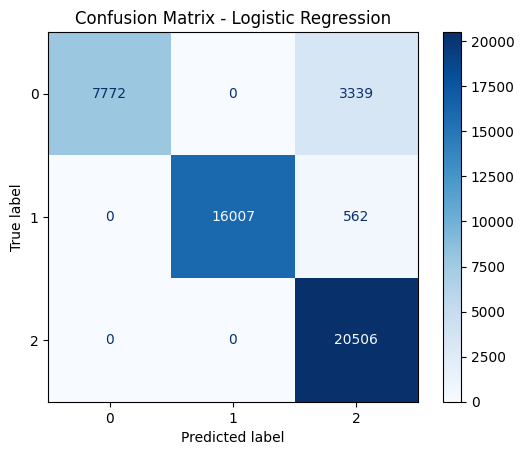

In [62]:
# Measure training time
start_time = time.time()# Train the model
training_time = time.time() - start_time

# Transform and predict
X_test_tfidf = tvec.transform(X_test)
y_pred = lr.predict(X_test_tfidf)

# Print evaluation
print("------ Logistic Regression --------")
print(f"Training time: {training_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



# SVM


In [34]:
#svm_model = SVC(kernel='linear', probability=True)  # kernel: 'linear', 'rbf', 'poly'
# svm_model = SVC(kernel='linear', C=1, random_state=42, probability=True)  # linear kernel for text classification
svm_model = LinearSVC(C=1, random_state=42)
svm_model.fit(train_bow, y_train)

LinearSVC(C=1, random_state=42)

------ SVM --------
Training time: 0.00 seconds
Accuracy: 0.9208276262814925
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.97      0.99     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186

Confusion Matrix:
 [[ 7772     0  3339]
 [    0 16093   476]
 [    0     0 20506]]


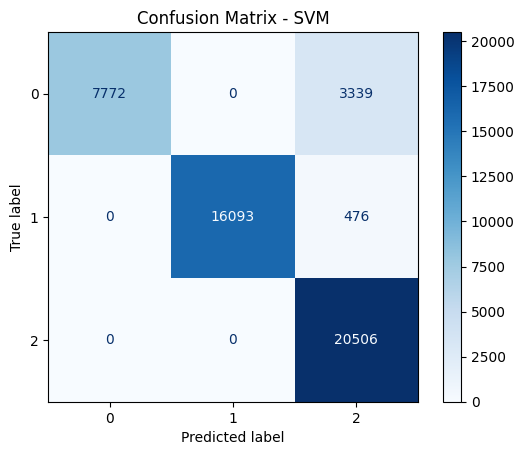

In [35]:
# 1. TF-IDF transform
X_train_tfidf = tvec.fit_transform(X_train)
X_test_tfidf = tvec.transform(X_test)

# 2. Train SVM model (with class_weight to handle imbalance)


start_time = time.time()
training_time = time.time() - start_time

# 3. Predict
y_pred = svm_model.predict(X_test_tfidf)

# 4. Evaluate
print("------ SVM --------")
print(f"Training time: {training_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 5. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 6. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()


In [36]:
new_texts = ["This movie is fantastic!", "I hate this track",'Son of a bitch   ']
new_vec = tvec.transform(new_texts)
print(lr.predict(new_vec))

[2 0 0]


# Decision Tree

In [37]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
dt_model.fit(train_bow, y_train)

DecisionTreeClassifier(random_state=42)

------ Decision Tree Classifier --------
Training time: 15.07 seconds
Accuracy: 0.9183787822189018
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.96      0.98     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186

Confusion Matrix:
 [[ 7768     0  3343]
 [    0 15979   590]
 [    0     0 20506]]


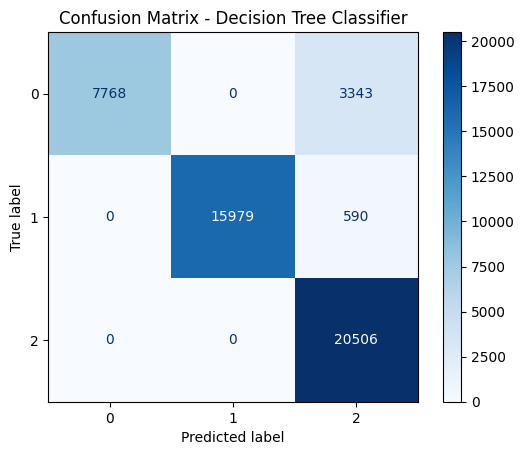

In [90]:
start_time = time.time()
training_time = time.time() - start_time

# Transform test data and predict
X_test_tfidf = tvec.transform(X_test)
y_pred = dt_model.predict(X_test_tfidf)

# Print evaluation results
print("------ Decision Tree Classifier --------")
print(f"Training time: {training_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()

# Naive bayes

In [92]:
nb = MultinomialNB()
nb.fit(train_bow, y_train)


MultinomialNB()

------ Naive Bayes Classifier --------
Training time: 0.00 seconds
Accuracy: 0.9221558128917113
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.98      0.99     16569
           2       0.85      1.00      0.92     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186

Confusion Matrix:
 [[ 7772     0  3339]
 [    0 16157   412]
 [    0     0 20506]]


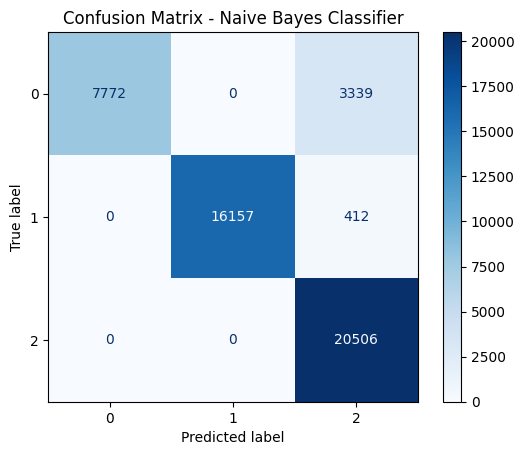

In [93]:

# Measure training time
start_time = time.time()
training_time = time.time() - start_time

# Predict
y_pred = nb.predict(X_test_tfidf)

# Print evaluation results
print("------ Naive Bayes Classifier --------")
print(f"Training time: {training_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes Classifier")
plt.show()

# KNN

In [94]:
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')  # You can adjust n_neighbors
knn.fit(train_bow, y_train)


KNeighborsClassifier(metric='cosine', n_neighbors=3)

------ K-Nearest Neighbors (KNN) --------
Training time: 0.00 seconds
Accuracy: 0.9198729921553979
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     11111
           1       1.00      0.98      0.99     16569
           2       1.00      0.83      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.91      0.94      0.92     48186
weighted avg       0.94      0.92      0.92     48186

Confusion Matrix:
 [[11111     0     0]
 [  412 16157     0]
 [ 3449     0 17057]]


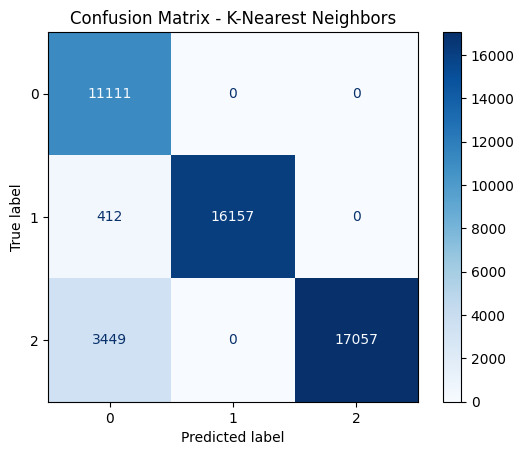

In [95]:
start_time = time.time()
training_time = time.time() - start_time

# Predict
X_test_tfidf = tvec.transform(X_test)
y_pred = knn.predict(X_test_tfidf)

# Print evaluation results
print("------ K-Nearest Neighbors (KNN) --------")
print(f"Training time: {training_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.show()

# Compare before fine tune

In [96]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

models = {
    "Logistic Regression": lr,
    "SVM": svm_model,
    "Decision Tree": dt_model,
    "Naive Bayes": nb,
    "KNN": knn
}

accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for name, model in models.items():
    y_pred = model.predict(tvec.transform(X_test))

    # Get metrics as dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Weighted averages
    accuracy_list.append(report['accuracy'])
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_list.append(report['weighted avg']['f1-score'])

    print(f"------ {name} ------")
    print(classification_report(y_test, y_pred))
    print()




------ Logistic Regression ------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.97      0.98     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186


------ SVM ------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.97      0.99     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186


------ Decision Tree ------
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.96      0.98    

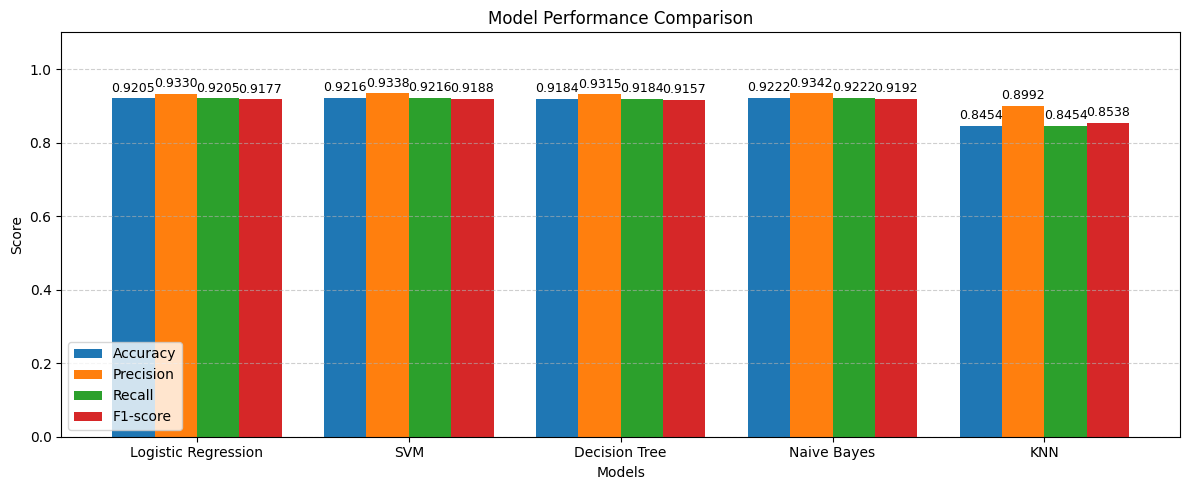

In [123]:
# Plot comparison
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12,5))

bars1 = plt.bar(x - 1.5*width, accuracy_list, width, label='Accuracy')
bars2 = plt.bar(x - 0.5*width, precision_list, width, label='Precision')
bars3 = plt.bar(x + 0.5*width, recall_list, width, label='Recall')
bars4 = plt.bar(x + 1.5*width, f1_list, width, label='F1-score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, list(models.keys()), rotation=None)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# === Add numeric values on top of bars ===
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.show()


# Fine tuned method

# Logistic Regression fine tuned

In [43]:
lr = LogisticRegression(max_iter=500)

L-BFGS: max iterations reached
Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
✅ Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Time: 31.53 seconds
------ Logistic Regression (Fine-tuned) --------
Accuracy: 0.9204955796289379
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.97      0.98     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186



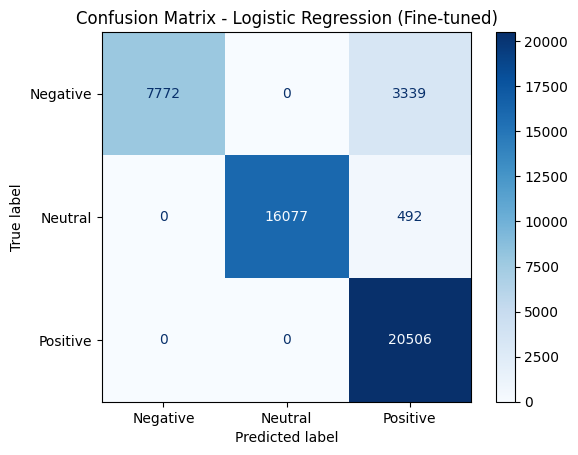

In [99]:

# -------------------------
# Step 2: Define hyperparameter grid to search
# -------------------------
param_grid = {
    'C': [0.01, 0.1, 1, 10],          # regularization strength
    'solver': ['liblinear', 'lbfgs'], # optimization algorithms
    'penalty': ['l2']                 # type of regularization
}

# -------------------------
# Step 3: Initialize GridSearchCV
# -------------------------
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # evaluation metric
    n_jobs=-1           # use all CPU cores
)

# -------------------------
# Step 4: Measure training time
# -------------------------
start_time = time.time()
grid_search.fit(train_bow, y_train)
training_time = time.time() - start_time

# -------------------------
# Step 5: Best model
# -------------------------
best_lr = grid_search.best_estimator_
print("✅ Best Hyperparameters:", grid_search.best_params_)
print(f"Training Time: {training_time:.2f} seconds")

# -------------------------
# Step 6: Evaluate performance
# -------------------------
X_test_tfidf = tvec.transform(X_test)
y_pred = best_lr.predict(X_test_tfidf)

print("------ Logistic Regression (Fine-tuned) --------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# -------------------------
# Step 7: Confusion matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (Fine-tuned)")
plt.show()

# SVM fine tuned

In [45]:
svm = LinearSVC(random_state=42, max_iter=5000)


✅ Best Hyperparameters (LinearSVC): {'C': 1, 'loss': 'hinge', 'penalty': 'l2'}
Training Time: 539.14 seconds
------ LinearSVC (Fine-tuned) --------
Accuracy: 0.9216369899970946
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.97      0.99     16569
           2       0.84      1.00      0.92     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186



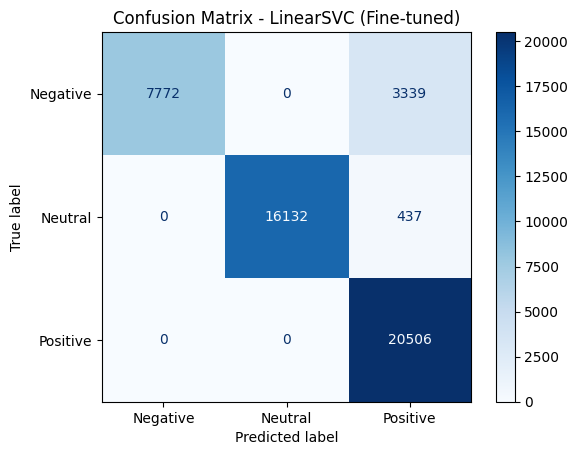

In [46]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge']
}

# Grid Search
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
grid_search.fit(tvec.transform(X_train), y_train)
training_time = time.time() - start_time

# Best model
best_svm = grid_search.best_estimator_
print("✅ Best Hyperparameters (LinearSVC):", grid_search.best_params_)
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate on test data
y_pred = best_svm.predict(tvec.transform(X_test))

print("------ LinearSVC (Fine-tuned) --------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LinearSVC (Fine-tuned)")
plt.show()

# Decision tree fine tuned

✅ Best Hyperparameters (Decision Tree): {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Training Time: 294.29 seconds
------ Decision Tree (Fine-tuned) --------
Accuracy: 0.9183787822189018
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.96      0.98     16569
           2       0.84      1.00      0.91     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186



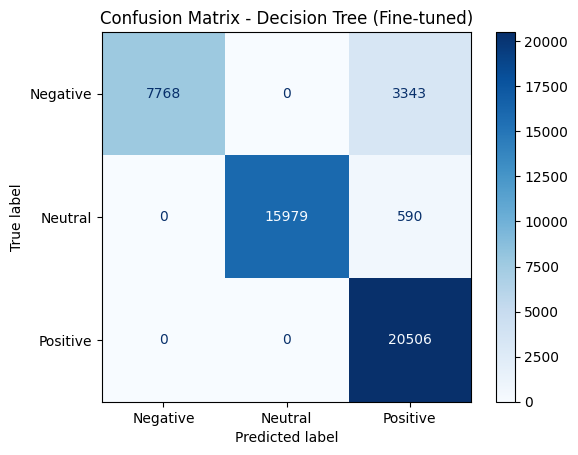

In [104]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
grid_search.fit(tvec.transform(X_train), y_train)
training_time = time.time() - start_time

best_dt = grid_search.best_estimator_
print("✅ Best Hyperparameters (Decision Tree):", grid_search.best_params_)
print(f"Training Time: {training_time:.2f} seconds")

y_pred = best_dt.predict(tvec.transform(X_test))
print("------ Decision Tree (Fine-tuned) --------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree (Fine-tuned)")
plt.show()

# Naive bayes fine tuned

In [48]:
nb = MultinomialNB()


✅ Best Hyperparameters (Naive Bayes): {'alpha': 0.01}
Training Time: 2.11 seconds
------ Naive Bayes (Fine-tuned) --------
Accuracy: 0.9221558128917113
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     11111
           1       1.00      0.98      0.99     16569
           2       0.85      1.00      0.92     20506

    accuracy                           0.92     48186
   macro avg       0.95      0.89      0.91     48186
weighted avg       0.93      0.92      0.92     48186



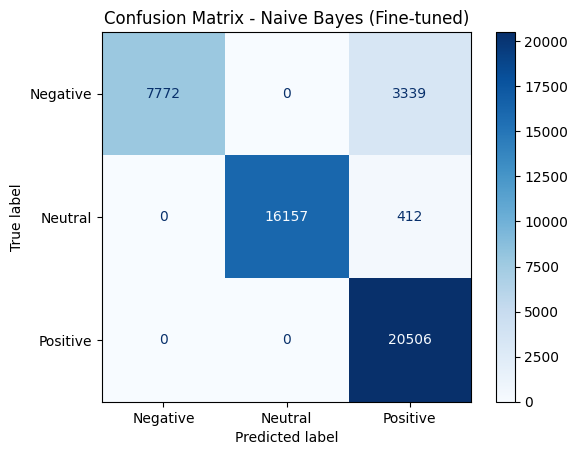

In [49]:

param_grid = {
    'alpha': [0.01, 0.1, 1, 10]  # smoothing parameter
}

grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
grid_search.fit(tvec.transform(X_train), y_train)
training_time = time.time() - start_time

best_nb = grid_search.best_estimator_
print("✅ Best Hyperparameters (Naive Bayes):", grid_search.best_params_)
print(f"Training Time: {training_time:.2f} seconds")

y_pred = best_nb.predict(tvec.transform(X_test))
print("------ Naive Bayes (Fine-tuned) --------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes (Fine-tuned)")
plt.show()

# KNN fine tuned

In [50]:
nb = MultinomialNB()

Unused keyword parameter: handle during CPU estimator initialization
Unused keyword parameter: verbose during CPU estimator initialization
Unused keyword parameter: output_type during CPU estimator initialization
Unused keyword parameter: leaf_size during cuML estimator initialization
Unused keyword parameter: n_jobs during cuML estimator initialization
Unused keyword parameter: leaf_size during cuML estimator initialization
Unused keyword parameter: n_jobs during cuML estimator initialization
Unused keyword parameter: leaf_size during cuML estimator initialization
Unused keyword parameter: n_jobs during cuML estimator initialization
Unused keyword parameter: leaf_size during cuML estimator initialization
Unused keyword parameter: n_jobs during cuML estimator initialization
Unused keyword parameter: leaf_size during cuML estimator initialization
Unused keyword parameter: n_jobs during cuML estimator initialization
Unused keyword parameter: leaf_size during cuML estimator initialization

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/cuml/internals/api_decorators.py", line 216, in wrapper
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/cuml/internals/api_decorators.py", line 368, in dispatch
    return self.dispatch_func(func_name, gp

Unused keyword parameter: leaf_size during cuML estimator initialization
Unused keyword parameter: n_jobs during cuML estimator initialization
✅ Best Hyperparameters (KNN): {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Training Time: 96.37 seconds
------ KNN (Fine-tuned) --------
Accuracy: 0.8453700244884407
              precision    recall  f1-score   support

           0       0.61      1.00      0.76     11111
           1       1.00      0.76      0.86     16569
           2       0.97      0.83      0.90     20506

    accuracy                           0.85     48186
   macro avg       0.86      0.86      0.84     48186
weighted avg       0.90      0.85      0.85     48186



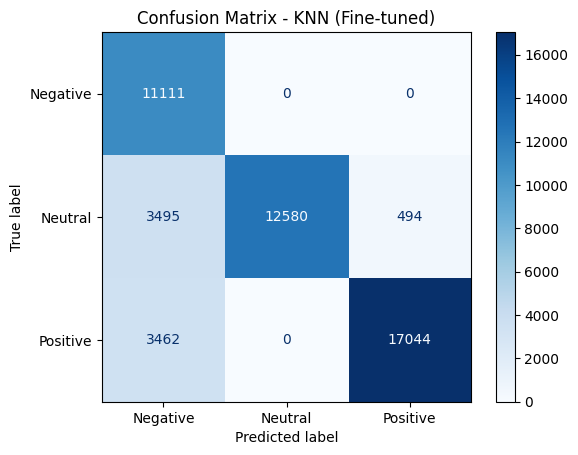

In [83]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
grid_search.fit(tvec.transform(X_train), y_train)
training_time = time.time() - start_time

best_knn = grid_search.best_estimator_
print("✅ Best Hyperparameters (KNN):", grid_search.best_params_)
print(f"Training Time: {training_time:.2f} seconds")

y_pred = best_knn.predict(tvec.transform(X_test))
print("------ KNN (Fine-tuned) --------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN (Fine-tuned)")
plt.show()

# Compare after fine tuned

In [100]:
# === Fine-tuned models ===
models = {
    "Logistic Regression": best_lr,   # fine-tuned
    "SVM": best_svm,                   # fine-tuned
    "Decision Tree": best_dt,          # fine-tuned
    "Naive Bayes": best_nb,            # fine-tuned
    "KNN": best_knn                     # fine-tuned
}

# === Collect metrics ===
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for name, model in models.items():
    y_pred = model.predict(tvec.transform(X_test))

    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_list.append(report['accuracy'])
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_list.append(report['weighted avg']['f1-score'])

    # Optional: print classification report and confusion matrix



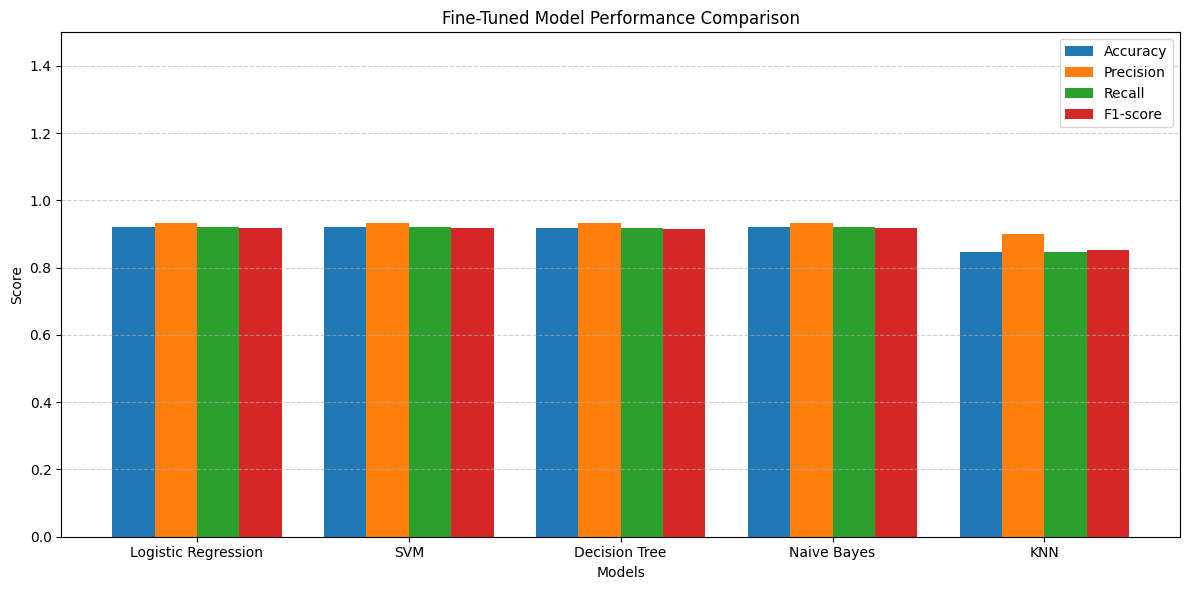

In [102]:

# === Plot grouped bar chart ===
x = np.arange(len(models))
width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Accuracy, Precision, Recall, F1

plt.figure(figsize=(12,6))
plt.bar(x - 1.5*width, accuracy_list, width, label='Accuracy', color=colors[0])
plt.bar(x - 0.5*width, precision_list, width, label='Precision', color=colors[1])
plt.bar(x + 0.5*width, recall_list, width, label='Recall', color=colors[2])
plt.bar(x + 1.5*width, f1_list, width, label='F1-score', color=colors[3])

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Fine-Tuned Model Performance Comparison')
plt.xticks(x, list(models.keys()), rotation=None)
plt.ylim(0, 1.5)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Combine F1-score

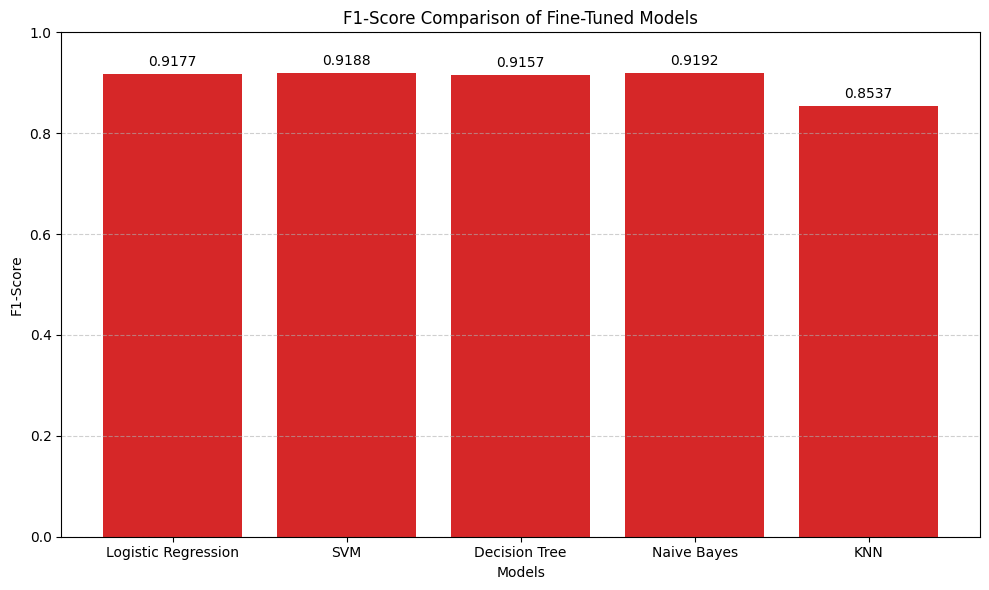

In [107]:
# Fine-tuned models
models = {
    "Logistic Regression": best_lr,
    "SVM": best_svm,
    "Decision Tree": best_dt,
    "Naive Bayes": best_nb,
    "KNN": best_knn
}

f1_scores = []

# Collect F1-score for each model
for name, model in models.items():
    y_pred = model.predict(tvec.transform(X_test))
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_scores.append(report['weighted avg']['f1-score'])

# Plot F1-score comparison
plt.figure(figsize=(10,6))
bars = plt.bar(models.keys(), f1_scores, color='#d62728')  # red for F1
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison of Fine-Tuned Models')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Optional: show numeric value on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


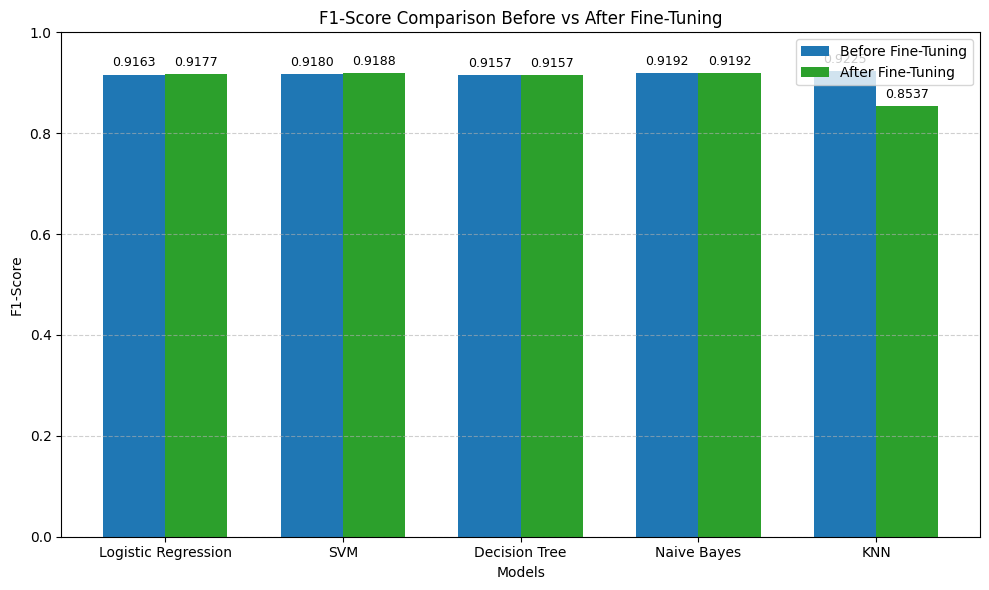

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# === Define base (before tuning) and fine-tuned models ===
before_tune_models = {
    "Logistic Regression": lr,
    "SVM": svm_model,
    "Decision Tree": dt_model,
    "Naive Bayes": nb,
    "KNN": knn
}

after_tune_models = {
    "Logistic Regression": best_lr,
    "SVM": best_svm,
    "Decision Tree": best_dt,
    "Naive Bayes": best_nb,
    "KNN": best_knn
}

# === Collect F1-scores ===
f1_before, f1_after = [], []

for name in before_tune_models.keys():
    # Before fine-tune
    y_pred_before = before_tune_models[name].predict(tvec.transform(X_test))
    report_before = classification_report(y_test, y_pred_before, output_dict=True)
    f1_before.append(report_before['weighted avg']['f1-score'])

    # After fine-tune
    y_pred_after = after_tune_models[name].predict(tvec.transform(X_test))
    report_after = classification_report(y_test, y_pred_after, output_dict=True)
    f1_after.append(report_after['weighted avg']['f1-score'])

# === Plot Comparison ===
x = np.arange(len(before_tune_models))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, f1_before, width, label='Before Fine-Tuning', color='#1f77b4')
bars2 = plt.bar(x + width/2, f1_after, width, label='After Fine-Tuning', color='#2ca02c')

plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison Before vs After Fine-Tuning')
plt.xticks(x, list(before_tune_models.keys()), rotation=None)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add numeric labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()
